In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import random
import shutil
from matplotlib.image import imread

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import time
import seaborn as sns
import pathlib

# import DCGAN as gan

import json

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [64]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [65]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [66]:
from pathlib import Path

data_root = Path('../PokemonData')

In [67]:
import random
all_image_paths = list(data_root.glob('*/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

6659

In [83]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names[:5]

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok']

In [70]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))

In [71]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [34, 75, 4, 30, 120, 90, 21, 27, 130, 136]


In [72]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

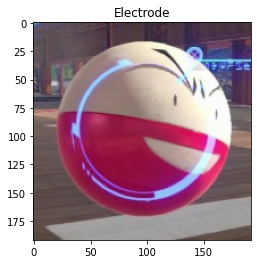

In [73]:
import matplotlib.pyplot as plt
img_path = all_image_paths[0]

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

In [74]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [81]:
for element in label_ds.as_numpy_iterator():
  print(element)
  break

34


In [82]:
for element in image_label_ds.as_numpy_iterator():
  print(element)
  break

(array([[[0.42026597, 0.5581643 , 0.7594166 ],
        [0.41871145, 0.5486021 , 0.74631107],
        [0.42747295, 0.55333155, 0.7328643 ],
        ...,
        [0.2975898 , 0.2073937 , 0.23876625],
        [0.28627452, 0.19607843, 0.22745098],
        [0.28344572, 0.19324963, 0.23027977]],

       [[0.43423316, 0.5570885 , 0.74397576],
        [0.4349332 , 0.54902965, 0.7348413 ],
        [0.4315402 , 0.53562284, 0.71094173],
        ...,
        [0.30041862, 0.21677892, 0.24487329],
        [0.28573668, 0.20209698, 0.23674771],
        [0.28253222, 0.1988925 , 0.23447146]],

       [[0.41960862, 0.5029318 , 0.67737156],
        [0.38595697, 0.46471286, 0.63314164],
        [0.34702072, 0.41764343, 0.57608277],
        ...,
        [0.30125597, 0.2204451 , 0.25098023],
        [0.28279996, 0.2019891 , 0.23728321],
        [0.28081086, 0.2       , 0.23529412]],

       ...,

       [[0.32003692, 0.2612134 , 0.24160555],
        [0.3163462 , 0.25752267, 0.23791483],
        [0.31033012, 

In [76]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)

In [77]:
BATCH_SIZE = 32

ds = image_label_ds.cache()
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [78]:
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [121]:
EPOCH = 100
image_shape = (192,192,3)

In [122]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

In [123]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [124]:
image_batch, label_batch = next(iter(keras_ds))

In [125]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [126]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

In [127]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.0001048474
max logit: 0.12293165

Shape: (32, 150)


In [128]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

209.0

In [129]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [130]:
model.fit(ds, epochs=10, steps_per_epoch=209)

Epoch 1/10
209/209 [==============================] - 11s 43ms/step - loss: 3.0219 - accuracy: 0.3847
Epoch 2/10
209/209 [==============================] - 9s 43ms/step - loss: 0.9416 - accuracy: 0.8209
Epoch 3/10
209/209 [==============================] - 9s 43ms/step - loss: 0.5029 - accuracy: 0.9234
Epoch 4/10
209/209 [==============================] - 9s 43ms/step - loss: 0.3004 - accuracy: 0.9628
Epoch 5/10
209/209 [==============================] - 9s 43ms/step - loss: 0.1930 - accuracy: 0.9842
Epoch 6/10
209/209 [==============================] - 9s 44ms/step - loss: 0.1297 - accuracy: 0.9927
Epoch 7/10
209/209 [==============================] - 9s 43ms/step - loss: 0.0911 - accuracy: 0.9960
Epoch 8/10
209/209 [==============================] - 9s 43ms/step - loss: 0.0702 - accuracy: 0.9972
Epoch 9/10
209/209 [==============================] - 9s 43ms/step - loss: 0.0555 - accuracy: 0.9970
Epoch 10/10
209/209 [==============================] - 9s 43ms/step - loss: 0.0447 - accur